In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('test_image.jpg')

In [4]:
"""
cv2.imshow('result',image)
if cv2.waitKey(0): #image will be shown for infinite amount of time untill we press some key
    cv2.destroyAllWindows()
"""

"\ncv2.imshow('result',image)\nif cv2.waitKey(0): #image will be shown for infinite amount of time untill we press some key\n    cv2.destroyAllWindows()\n"

In [5]:
#image = cv2.resize(image,(800,600))

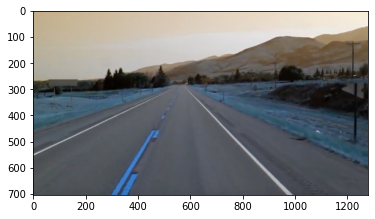

In [6]:
plt.imshow(image)

In [7]:
lane_image = image.copy()

In [8]:
def canny(image):
    #to create gray scale image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    canny = cv2.Canny(blur,50,150) #sobel transform
    return canny

In [9]:
canny_image = canny(lane_image)

In [10]:
"""
cv2.imshow('result',canny_image)
if cv2.waitKey(0):
    cv2.destroyAllWindows()
"""

"\ncv2.imshow('result',canny_image)\nif cv2.waitKey(0):\n    cv2.destroyAllWindows()\n"

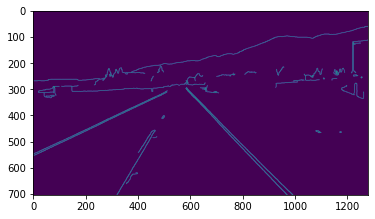

In [11]:
plt.imshow(canny_image)
#now we want to isolate our region of interest
#that will be traingle shaped area at the right (for this program we will consider right)
#we have used plt to find out the coordinate of region of interest
#and in this case they are (200,700), (1100,700), (550,250)

In [12]:
#addition start

In [13]:
height = lane_image.shape[0]
width = lane_image.shape[1]

region_of_interest_pts = np.float32([(520,300),(200,height),(1100,height),(595,300)])
#region_of_interest_pts = np.float32([(0,height//2),(0,0),(width,height),(width,height//2)])

desired_region_of_interest_pts = np.float32([[0, 0],[0, height],[width, height],[width, 0]])
def region_of_interest(image):
    height = image.shape[0]  #row
    #polygons = np.array([[(500,370),(200,height),(1100,height),(550,250)]]) #region of interest
    polygons = np.array([[(0,height//2),(0,0),(width,height),(width,height//2)]])
    mask = np.zeros_like(image) #create an array of 0 of size image i.e no. of pixels will be equal
    cv2.fillPoly(mask,polygons,255) #here we are merging mask and polygon and we color of the polygon will be 255(white)
    #why are we doing this?
    #we want to mask the unnecessary things in the image, so we will perform bitwise 'and' operation on our canny image and
    #our merged image(i.e. o/p of fillPoly). In merged image the area outside the polygon is colored black(ie 0),
    #so when we will perform bitwise 'and' operation bcoz the 0, unwanted things in the image will become 0 i.e. "black".
    
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image
cropped_image = region_of_interest(canny_image)

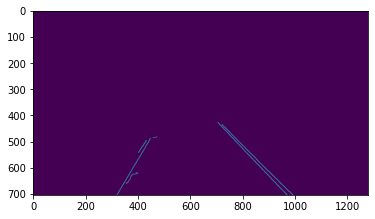

In [14]:
def region_of_interest(img):
    mask = np.zeros_like(img)   
    
    imshape = img.shape    
    if len(imshape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vertices = np.array([[(0,imshape[0]),(imshape[1]*.48, imshape[0]*.58), (imshape[1]*.52, imshape[0]*.58), (imshape[1],imshape[0])]], dtype=np.int32)              
    cv2.fillPoly(mask, vertices, ignore_mask_color)   
    masked_image = cv2.bitwise_and(img, mask)
    plt.imshow(masked_image)
    return masked_image
cropped_image = region_of_interest(canny_image)

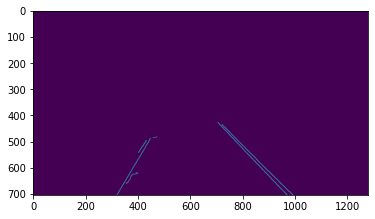

In [15]:
#binary thresholding
#we are converting pixel value above 127 into 255 and if value is less than 127 will set it to 0
threshold_value,cropped_image_binary = cv2.threshold(cropped_image[:,:], 127, 255, cv2.THRESH_BINARY)
cropped_image_binary.shape
plt.imshow(cropped_image_binary)

In [16]:
#hough transform
lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)

In [17]:
print(lines)
#there are the x1,y1,x2,y2 coordinates of lines

[[[853 568 898 613]]

 [[787 514 969 702]]

 [[900 613 976 689]]

 [[356 642 449 487]]

 [[750 465 834 549]]

 [[861 590 909 639]]

 [[320 703 444 496]]

 [[721 435 927 641]]

 [[705 427 766 490]]

 [[767 493 807 533]]]


In [18]:
def find_coordinates(image, line_parameters):
    print(line_parameters)
    try:
        slope, intercept = line_parameters
    except TypeError:
        slope, intercept = 0.001,0
    #slope, intercept = line_parameters
    y1 = image.shape[0] #height of the image bcoz lines are statring from bottom
    y2 = int(y1*(3/5)) #y2 is 3/5 of y1
    x1 = int((y1-intercept)/slope) #converted to int bcoz opencv gives errors for another data types 
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [19]:
#optimising lines drawn on the image
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4) #POLYFIT -finding the best fitting curve to a given set of points
        parameters = np.polyfit((x1,x2),(y1,y2),1) #returns [slope,y-intercept]
        slope = parameters[0]
        intercept = parameters[1]
        
        '''
        doubt!!!
        slope = (y2-y1)/(x2-x1)
        print(slope,"slope")
        intercept = (y2-y1) + slope*x2 #y-intercept
        print(intercept,'intercept')
        '''
        if slope<0:
            left_fit.append((slope,intercept)) #all the left lines of the left lane
        else:
            right_fit.append((slope,intercept)) #all the right lines of the right lane
        #array of multiple rows and 2 columns thats why axis = 0, like in pandas i.e.columnwise
        
    left_fit_average = np.average(left_fit,axis =0) #to make a one line of all left lines
    right_fit_average = np.average(right_fit,axis =0) #to make a one line of all right lines
    
    left_line = find_coordinates(image,left_fit_average)
    right_line = find_coordinates(image,right_fit_average)
    return np.array([left_line,right_line])
    

In [20]:
#to draw lines over image - (not optimised , drawing multiple lines on image)
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1,y1), (x2,y2), color = (255,0,0), thickness= 10)
    #line_image is an image with black background and represented lines in blue(255,0,0 BGR).
    #then we will merge this black image with lanes on it with the original image,
    #because line_image bg is black(0) it will not affect the intensity of original pic when we will add them
    #bcoz x + 0 = x  (i.e. x doesn't change)
    return line_image

In [21]:
#filling the gap between two lines
"""
#to draw lines over image - (not optimised , drawing multiple lines on image)
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        left1 = lines[0,0:2]
        left2 = lines[0,2:]
        right1 = lines[1,0:2]
        right2 = lines[1,2:]
        right = lines[1]
        #print(left[0])
        #print(type(left[0]))
        pts = np.array([left1,left2,right2,right1],np.int32)
  
        pts = pts.reshape((-1, 1, 2))
        #print(lines,left1,left2,right1,right2)

        output_2 = cv2.fillPoly(image,[pts],color=(255,255,255)) 
        
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1,y1), (x2,y2), color = (255,255,255), thickness= 10
         
            
    #line_image is an image with black background and represented lines in blue(255,0,0 BGR).
    #then we will merge this black image with lanes on it with the original image,
    #because line_image bg is black(0) it will not affect the intensity of original pic when we will add them
    #bcoz x + 0 = x  (i.e. x doesn't change)
    #return line_image
    return output_2
    """

"\n#to draw lines over image - (not optimised , drawing multiple lines on image)\ndef display_lines(image,lines):\n    line_image = np.zeros_like(image)\n    if lines is not None:\n        left1 = lines[0,0:2]\n        left2 = lines[0,2:]\n        right1 = lines[1,0:2]\n        right2 = lines[1,2:]\n        right = lines[1]\n        #print(left[0])\n        #print(type(left[0]))\n        pts = np.array([left1,left2,right2,right1],np.int32)\n  \n        pts = pts.reshape((-1, 1, 2))\n        #print(lines,left1,left2,right1,right2)\n\n        output_2 = cv2.fillPoly(image,[pts],color=(255,255,255)) \n        \n        for x1, y1, x2, y2 in lines:\n            cv2.line(line_image, (x1,y1), (x2,y2), color = (255,255,255), thickness= 10\n         \n            \n    #line_image is an image with black background and represented lines in blue(255,0,0 BGR).\n    #then we will merge this black image with lanes on it with the original image,\n    #because line_image bg is black(0) it will not af

[  -1.66801075 1236.26344086]
[   1.01082341 -288.24966363]


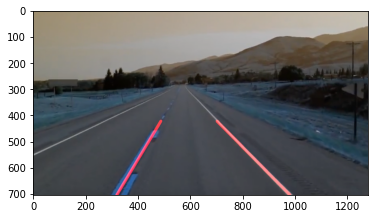

In [22]:
#cropped_image = region_of_interest(canny)
#cv2.imshow('result',region_of_interest(cropped_image))
averaged_lines = average_slope_intercept(lane_image,lines)
line_image = display_lines(lane_image,averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image , 1,1)
plt.imshow(combo_image)

In [23]:
output_first = combo_image.copy()

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
#now we have to do this for each frame in video
road_video = cv2.VideoCapture("test2.mp4")
while(road_video.isOpened()):
    _,frame = road_video.read() #replace lane_image with frame
    if _ == True:
        
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame,lines)
        line_image = display_lines(frame,averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image , 1,1)
        
        cv2.imshow('result',combo_image)
        plt.imshow(combo_image)
        if cv2.waitKey(25) == ord('q'):
            
            break
        
cv2.destroyAllWindows()
road_video.release()



#

In [23]:
def canny(image):
    #to create gray scale image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5),0)
    canny = cv2.Canny(blur,50,150) #sobel transform
    return canny

In [24]:
canny_image2 = canny(output_first)

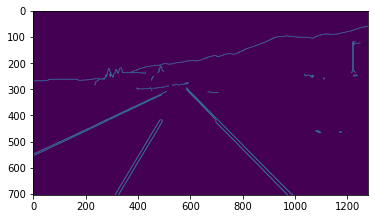

In [25]:
plt.imshow(canny_image2)

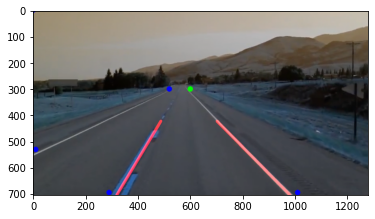

In [26]:
#to find region of interest point
height = lane_image.shape[0]
width = lane_image.shape[1]
exp_image = output_first.copy()
cv2.circle(exp_image, (520,300), radius=5, color=(0, 0, 255), thickness=10)
cv2.circle(exp_image, (10,530), radius=5, color=(0, 0, 255), thickness=10)
cv2.circle(exp_image, (0,0), radius=5, color=(0, 0, 255), thickness=10)
cv2.circle(exp_image, (290,height-10), radius=5, color=(0, 0, 255), thickness=10)
cv2.circle(exp_image, (1010,height-10), radius=5, color=(0, 0, 255), thickness=10)
cv2.circle(exp_image, (600,300), radius=5, color=(0, 255, 0), thickness=10)
    #break
#print(exp_image)
plt.imshow(exp_image)

In [27]:
#cropped_image = canny_image.copy()

In [28]:
region_of_interest_pts

array([[ 520.,  300.],
       [ 200.,  704.],
       [1100.,  704.],
       [ 595.,  300.]], dtype=float32)

In [29]:
height = canny_image2.shape[0]
width = canny_image2.shape[1]
#imshape = lane_image.shape
def perspective_transformation(output_first,region_of_interest_pts):
    #region_of_interest_pts = np.float32([(520,300),(290,height),(1010,height),(600,300)]) **
    #region_of_interest_pts = np.array([[(0,imshape[0]),(imshape[1]*.48, imshape[0]*.58), (imshape[1]*.52, imshape[0]*.58), (imshape[1],imshape[0])]], dtype=np.float32)              

    #desired_region_of_interest_pts = np.float32([(0,0),(height,0),(width,height),(width,0)])
    desired_region_of_interest_pts = np.float32([[0, 0],[0, height],[width, height],[width, 0]])
    # Calculate the transformation matrix
    transformation_matrix = cv2.getPerspectiveTransform(region_of_interest_pts,desired_region_of_interest_pts)
    # Calculate the inverse transformation matrix
    inv_transformation_matrix = cv2.getPerspectiveTransform(desired_region_of_interest_pts,region_of_interest_pts)
    warped_image = cv2.warpPerspective(output_first,transformation_matrix,(width,height),flags=(cv2.INTER_LINEAR))
    warped_image_copy = warped_image.copy()
    warped_plot = cv2.polylines(warped_image_copy, [desired_region_of_interest_pts.astype("int32")], True, (255,255,255), 50)
    #cv2.polylines(exp , [region_of_interest_pts] , True , (255,255,255)  , 5)
    #plt.imshow(warped_image)
    return warped_image,inv_transformation_matrix

In [30]:
warped_image,inv_transformation_matrix = perspective_transformation(output_first,region_of_interest_pts)

In [31]:
warped_image.shape

(704, 1279, 3)

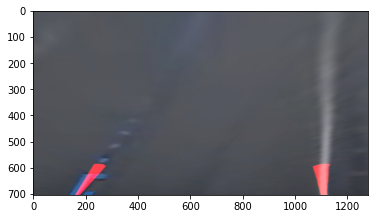

In [32]:
plt.imshow(warped_image)

In [33]:
#plotting histogram
#binary thresholding
#we are converting pixel value above 127 into 255 and if value is less than 127 will set it to 0
threshold_value,warped_image_binary = cv2.threshold(warped_image[:,:,0], 127, 255, cv2.THRESH_BINARY)

warped_image_binary.shape

(704, 1279)

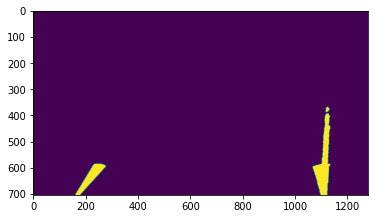

In [34]:
plt.imshow(warped_image_binary)

In [35]:
#wea re taking across the channels
#histogram = np.sum(warped_image_binary[int(warped_image_binary.shape[0]/2):,:], axis=0)
histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)
histogram.shape

(1279,)

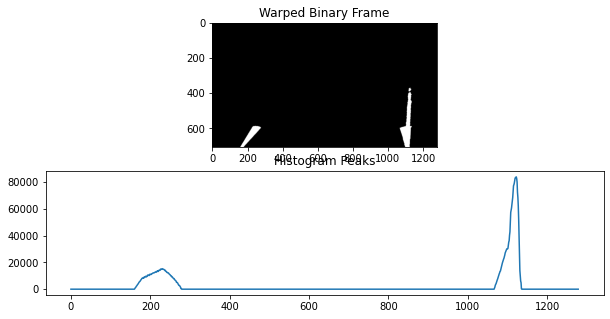

In [36]:
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 5)
ax1.imshow(warped_image_binary, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

In [37]:
#here we get the left and right peak of histogram

def histogram_peak_indices(histogram):
    print(histogram.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx = np.argmax(histogram[0:midpoint])
    rightx = np.argmax(histogram[midpoint:]) + midpoint
    return leftx,rightx

In [38]:
histogram_peak_indices(histogram)

(1279,)


(230, 1122)

In [39]:
# Sliding window parameters
no_of_windows = 10
margin = int((1/12) * width)  # Window width is +/- margin
minpix = int((1/24) * width)

In [47]:
def get_line_indices_sliding_windows(warped_image_binary):
    frame_sliding_window = warped_image_binary.copy()
    
    #to set height of the sliding window
    window_height = np.int(warped_image_binary.shape[0]/no_of_windows)
    
    #to find the nonzero(white) pixels in the frame
    nonzero = warped_image_binary.nonzero() #returns indices with nonzero elements
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    #print(nonzerox,"nonzerox")
    #to store the pixel indices for left and right lane lines
    left_lane_inds = []
    right_lane_inds = []
    
    #current position for pixel indices for each window which we will update conti.
    leftx_base, rightx_base = histogram_peak_indices(histogram)
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    for window in range(no_of_windows):
        
        #identify window boundaries in x and y
        win_y_low = warped_image_binary.shape[0] - (window + 1) * window_height
        win_y_high = warped_image_binary.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #in cv2.rectancle 1st tuple is top-left corner coordinates & 2nd tuple is bottom-right coordinates
        #this 1st is for the left lane
        cv2.rectangle(frame_sliding_window, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high), (255,255,255), thickness=2)
        #this is for the right lane
        cv2.rectangle(frame_sliding_window, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (255,255,255), 2)
        
        #identify the x and y of nonzero pixels within the window
        #nonzero returns a tuple but we want only the array of nonzero indices so we did nonzero()[0] **
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(good_right_inds,"good_right_inds")
        #append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #if you found > minpix(minimun no.of pixels) pixels, recenter next window on mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #print(right_lane_inds,"right_lane_inds")
    #concatenate array of indices
    #np.concatenate concatenates all the arrays to create one single array
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #extract the pixel coordinates from left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] 
    righty = nonzeroy[right_lane_inds]
    
    #fit a 2 degree polynomial curve to the pixel coordinates
    #the left and right lane lines
    #print(rightx,righty,"rightx,righty")
    #print(lefty,leftx,"lefty,leftx")
    left_fit = np.polyfit(lefty, leftx, deg = 2)
    right_fit = np.polyfit(righty, rightx,deg= 2)

    #create the x and y values to plot on the image
    ploty = np.linspace(0, frame_sliding_window.shape[0]-1, frame_sliding_window.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    #visualization
    #print(frame_sliding_window.shape)
    out_img = np.dstack((frame_sliding_window, frame_sliding_window, (frame_sliding_window))) * 255

    #adding color to left line pixels and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = (255,0,0)
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = (0,0,255)
    
    '''
    figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
    figure.set_size_inches(10, 10)
    figure.tight_layout(pad=3.0)
    ax1.imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
    ax2.imshow(frame_sliding_window, cmap='gray')
    ax3.imshow(out_img)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax1.set_title("Original Frame")  
    ax2.set_title("Warped Frame with Sliding Windows")
    ax3.set_title("Detected Lane Lines with Sliding Windows")
    #plt.show()
    
    #plt.imshow(out_img)
    '''
    #plt.imshow(frame_sliding_window)
    return left_fit, right_fit

(1279,)


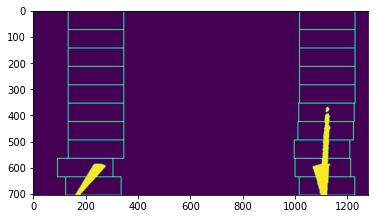

In [48]:
left_fit, right_fit = get_line_indices_sliding_windows(warped_image_binary)


In [51]:
def get_lane_line_previous_window(warped_image_binary,left_fit, right_fit):
    
    #to find the nonzero(white) pixels in the frame
    nonzero = warped_image_binary.nonzero() #returns indices with nonzero elements
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
         
    # Store left and right lane pixel indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (
      nonzerox < (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (
      nonzerox < (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))           
 
    # Get the left and right lane line pixel locations  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]      
     
    # Fit a second order polynomial curve to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
         
    # Create the x and y values to plot on the image
    ploty = np.linspace(
      0, warped_image_binary.shape[0]-1, warped_image_binary.shape[0]) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
         
    # Generate images to draw on
    out_img = np.dstack((warped_image_binary, warped_image_binary, (warped_image_binary)))*255
    window_img = np.zeros_like(out_img)

    # Add color to the left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Create a polygon to show the search window area, and recast 
    # the x and y points into a usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([
                                 right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                 right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the figures 
    '''
    figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
    figure.set_size_inches(10, 10)
    figure.tight_layout(pad=3.0)
    ax1.imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
    ax2.imshow(warped_image_binary, cmap='gray')
    ax3.imshow(result)
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax1.set_title("Original Frame")  
    ax2.set_title("Warped Frame")
    ax3.set_title("Warped Frame With Search Window")
    plt.show()
    '''
    
    return left_fitx,right_fitx,ploty

In [54]:
left_fitx,right_fitx,ploty = get_lane_line_previous_window(warped_image_binary, left_fit, right_fit)

In [55]:
def overlay_lane_lines(warped_image_binary,left_fitx,right_fitx,ploty,inv_transformation_matrix):
    #print(warped_image_binary.shape,"warped_image_binary.shape")
    plt.imshow(warped_image_binary)
    # Generate an image to draw the lane lines on 
    warp_zero = np.zeros_like(warped_image_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))       
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([
                            left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([
                            right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_transformation_matrix, (
                                    lane_image.shape[
                                    1], lane_image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(lane_image, 1, newwarp, 0.3, 0)
    ##########################################
    '''
    # Create the x and y values to plot on the image
    ploty = np.linspace(
      0, warped_image_binary.shape[0]-1, warped_image_binary.shape[0]) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
         
    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 
    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_transformation_matrix, (
                                  lane_image.shape[
                                  1], lane_image.shape[0]))
     
    # Combine the result with the original image
    result = cv2.addWeighted(lane_image, 1, newwarp, 0.3, 0)
      
    # Plot the figures 
    
    figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
    figure.set_size_inches(10, 10)
    figure.tight_layout(pad=3.0)
    ax1.imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Frame")  
    ax2.set_title("Original Frame With Lane Overlay")
    plt.show()   
    
    '''
    plt.imshow(result)
    return result

array([[[116,  91,  75],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [248, 238, 215],
        [248, 238, 215],
        [248, 238, 215]],

       [[157, 133, 106],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [247, 238, 215],
        [247, 238, 215],
        [247, 238, 215]],

       [[185, 163, 127],
        [194, 174, 134],
        [194, 174, 134],
        ...,
        [247, 238, 215],
        [247, 238, 215],
        [247, 238, 215]],

       ...,

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 73,  74,  82],
        [ 73,  74,  82],
        [ 73,  74,  82]],

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 72,  73,  81],
        [ 72,  73,  81],
        [ 72,  73,  81]],

       [[ 74,  80,  85],
        [ 74,  80,  85],
        [ 74,  80,  85],
        ...,
        [ 72,  73,  81],
        [ 72,  73,  81],
        [ 72,  73,  81]]

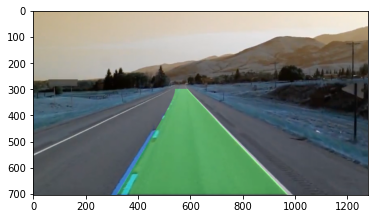

In [56]:
overlay_lane_lines(warped_image_binary,left_fitx,right_fitx,ploty,inv_transformation_matrix)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#now we have to do this for each frame in video
road_video = cv2.VideoCapture("test2.mp4")
i=0
while(road_video.isOpened()):
    flag = True
    _,frame = road_video.read() #replace lane_image with frame
    if _ == True:
        
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame,lines)
        line_image = display_lines(frame,averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image , 1,1)
        
        output_first = combo_image.copy()
        canny_image2 = canny(output_first)
          # Resize the frame
        '''
          width = int(frame.shape[1] * scale_ratio)
          height = int(frame.shape[0] * scale_ratio)
          frame = cv2.resize(frame, (width, height))
          '''
        # Perform the perspective transform to generate a bird's eye view
        # If Plot == True, show image with new region of interest
        warped_frame = perspective_transformation(canny_image2,region_of_interest_pts)
        
        # Generate the image histogram to serve as a starting point
        # for finding lane line pixels
        
        threshold_value,warped_image_binary = cv2.threshold(warped_image[:,:,0], 127, 255, cv2.THRESH_BINARY)

        histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)

        # Find lane line pixels using the sliding window method 
        left_fit, right_fit = get_line_indices_sliding_windows(warped_image_binary)
        # Fill in the lane line
        left_fitx,right_fitx,ploty = get_lane_line_previous_window(warped_image_binary,left_fit, right_fit)
        #result1 = result1[:,:]

        # Overlay lines on the original frame
        frame_with_lane_lines = overlay_lane_lines(warped_image_binary,left_fitx,right_fitx,ploty,inv_transformation_matrix)
        '''
        # Calculate lane line curvature (left and right lane lines)
        lane_obj.calculate_curvature(print_to_terminal=False)

        # Calculate center offset  																
        lane_obj.calculate_car_position(print_to_terminal=False)

        # Display curvature and center offset on image
        frame_with_lane_lines2 = lane_obj.display_curvature_offset(
        frame=frame_with_lane_lines, plot=False)
        '''
        # Write the frame to the output video file
        #result.write(frame_with_lane_lines2)

        # Display the frame 
        cv2.imshow("Frame", frame_with_lane_lines) 	
        plt.imshow(frame_with_lane_lines)
        # Display frame for X milliseconds and check if q key is pressed
        # q == quit
        if cv2.waitKey(1) == ord('q'):
            break
        
    # No more video frames left
    else:
        break
    i+=1
			
# Stop when the video is finished
road_video.release()

# Release the video recording
road_video.release()

# Close all windows
cv2.destroyAllWindows()
print("hi")

NameError: name 'canny' is not defined

In [ ]:
result1.shape

In [ ]:
warped_image_binary.shape

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
#now we have to do this for each frame in video
road_video = cv2.VideoCapture("test2.mp4")
i=0
while(road_video.isOpened()):
    flag = True
    _,frame = road_video.read() #replace lane_image with frame
    if _ == True:
        
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame,lines)
        line_image = display_lines(frame,averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image , 1,1)
        
        output_first = combo_image.copy()
        canny_image2 = canny(output_first)
        warped_image,inv_transformation_matrix = perspective_transformation(canny_image2,region_of_interest_pts)
        #binary thresholding
        threshold_value,warped_image_binary = cv2.threshold(warped_image[:,:], 127, 255, cv2.THRESH_BINARY)
        histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)
        if i==0:
            
            left_fit, right_fit = get_line_indices_sliding_windows(warped_image_binary)
            result = overlay_lane_lines(warped_image_binary,inv_transformation_matrix)
            plt.imshow(result)
            flag = False
            print(result.shape,"result.shape")
            print(left_fit.shape,"left.fit")
            print(right_fit.shape,"left.fit")

        else:
            result = get_lane_line_previous_window(warped_image_binary, left_fit, right_fit)
            
            result = overlay_lane_lines(result[:,:,0],inv_transformation_matrix)
            print(result.shape,"result.shape")
            plt.imshow(result)
            print(left_fit,"left.fit")
            print(right_fit,"left.fit")
        i+=1
        
        '''
        cv2.imshow('result',result)
        if cv2.waitKey(25) == ord('q'):

            break

cv2.destroyAllWindows()
road_video.release()
'''


In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
#now we have to do this for each frame in video
road_video = cv2.VideoCapture("test2.mp4")
i=0
while(road_video.isOpened()):
    flag = True
    _,frame = road_video.read() #replace lane_image with frame
    if _ == True:
        
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame,lines)
        line_image = display_lines(frame,averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image , 1,1)
        
        output_first = combo_image.copy()
        canny_image2 = canny(output_first)
        warped_image,inv_transformation_matrix = perspective_transformation(canny_image2,region_of_interest_pts)
        #binary thresholding
        threshold_value,warped_image_binary = cv2.threshold(warped_image[:,:], 127, 255, cv2.THRESH_BINARY)
        histogram = np.sum(warped_image_binary[warped_image_binary.shape[0]//2:,:], axis=0)
        if i==0:
            
            left_fit, right_fit = get_line_indices_sliding_windows(warped_image_binary)
            result = overlay_lane_lines(warped_image_binary,inv_transformation_matrix)
            plt.imshow(result)
            flag = False
            print(result.shape,"result.shape")
            print(left_fit.shape,"left.fit")
            print(right_fit.shape,"left.fit")

        else:
            result = get_lane_line_previous_window(warped_image_binary, left_fit, right_fit)
            
            result = overlay_lane_lines(result[:,:,0],inv_transformation_matrix)
            print(result.shape,"result.shape")
            plt.imshow(result)
            print(left_fit,"left.fit")
            print(right_fit,"left.fit")
        i+=1
        
        '''
        cv2.imshow('result',result)
        if cv2.waitKey(25) == ord('q'):

            break

cv2.destroyAllWindows()
road_video.release()
'''


In [ ]:
#to draw lines over image - (not optimised , drawing multiple lines on image)
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1,y1), (x2,y2), color = (255,0,0), thickness= 10)
    #line_image is an image with black background and represented lines in blue(255,0,0 BGR).
    #then we will merge this black image with lanes on it with the original image,
    #because line_image bg is black(0) it will not affect the intensity of original pic when we will add them
    #bcoz x + 0 = x  (i.e. x doesn't change)
    return line_image

In [ ]:
#cropped_image = region_of_interest(canny)
#cv2.imshow('result',region_of_interest(cropped_image))
averaged_lines = average_slope_intercept(lane_image,lines)
line_image = display_lines(lane_image,averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image , 1,1)
cv2.imshow('result',combo_image)
if cv2.waitKey(0):
    cv2.destroyAllWindows()

In [ ]:
#now we have to do this for each frame in video
road_video = cv2.VideoCapture("test2.mp4")
while(road_video.isOpened()):
    _,frame = road_video.read() #replace lane_image with frame
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength= 40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame,lines)
    line_image = display_lines(frame,averaged_lines)
    combo_image = cv2.addWeighted(frame, 0.8, line_image , 1,1)
    cv2.imshow('result',combo_image)
    if cv2.waitKey(0) and 0xff == ord('q'):
        cv2.destroyAllWindows()
        video.release()
        break


# Perspective Transformation

In [ ]:
#perspective transformation
#(500,300),(200,height),(1100,height),(550,250) region of interest
#(0,0),(height,0),(width,height),(width,0)

In [ ]:
plt.imshow(canny_image)

In [ ]:
height = lane_image.shape[0]
width = lane_image.shape[1]

region_of_interest_pts = np.float32([(520,300),(200,height),(1100,height),(595,300)])
#region_of_interest_pts = np.int32([(500,300),(200,height),(1100,height),(550,250)])
#desired_region_of_interest_pts = np.float32([(0,0),(height,0),(width,height),(width,0)])
desired_region_of_interest_pts = np.float32([[0, 0],[0, height],[width, height],[width, 0]])

In [ ]:
# Calculate the transformation matrix
transformation_matrix = cv2.getPerspectiveTransform(region_of_interest_pts,desired_region_of_interest_pts)
# Calculate the inverse transformation matrix
inv_transformation_matrix = cv2.getPerspectiveTransform(desired_region_of_interest_pts,region_of_interest_pts)

In [ ]:
lane_image.shape

In [ ]:
warped_image = cv2.warpPerspective(lane_image,transformation_matrix,(1279,704),flags=(cv2.INTER_LINEAR))
warped_image_copy = warped_image.copy()

In [ ]:
warped_plot = cv2.polylines(warped_image_copy, [desired_region_of_interest_pts.astype("int32")], True, (255,255,255), 50)
#cv2.polylines(exp , [region_of_interest_pts] , True , (255,255,255)  , 5)


In [ ]:
plt.imshow(warped_image)

In [ ]:
type(warped_image)

In [ ]:
exp = lane_image.copy()

In [ ]:
exp = lane_image.copy()
region_of_interest_pts = np.float32([(520,300),(200,height),(1100,height),(595,300)])


In [ ]:
cv2.polylines(exp , [region_of_interest_pts] , True , (255,255,255)  , 5)
cv2.imshow('result',exp)
if cv2.waitKey(0):
    cv2.destroyAllWindows()

In [ ]:
plt.imshow(warped_image_copy)